# Introduction
Ce notebook présente une modélisation des précipitations avec Prophet, suivie de recommandations agricoles et d’irrigation. Il s’inscrit dans le cadre du projet Hack2Hire.

In [ ]:
#  Recharger le fichier CSV depuis mon ordinateur
from google.colab import files
uploaded = files.upload()

Saving rain_predictions.csv to rain_predictions.csv


In [ ]:
#  Importation des données de précipitations

import pandas as pd
# Charger les données
df = pd.read_csv("rain_predictions.csv")
df.head()
print(df.columns)
df = df.rename(columns={"date": "ds", "precipitation": "y"})



Index(['timestamp_utc', 'year', 'month', 'day', 'hour', 'minute', 'second',
       'lat', 'lon', 'site_id', 'precipitation', 'precipitation_probability',
       'precip_24h_mm', 'precip_7d_mm', 'precip_30d_mm', 'cloudcover',
       'windspeed_10m', 'winddirection_10m', 'soil_moisture_0_to_7cm',
       'soil_temperature_0_to_7cm'],
      dtype='object')


In [ ]:
# Nettoyer les données
df['ds'] = pd.to_datetime(df['timestamp_utc'], errors='coerce').dt.tz_localize(None)
df['y'] = df['precip_24h_mm']
df_prophet = df[['ds', 'y']].copy()
df_prophet['y'] = df_prophet['y'].apply(lambda x: max(x, 0))
df_prophet = df_prophet.dropna(subset=['ds', 'y'])

In [ ]:
# Install prophet
!pip install prophet

In [ ]:
#  Entraînement  du modèle Prophet sur les données nettoyées

from prophet import Prophet

In [ ]:
from prophet import Prophet

# Initialisation du modèle
model = Prophet()

# Entraînement sur les données
model.fit(df_prophet)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


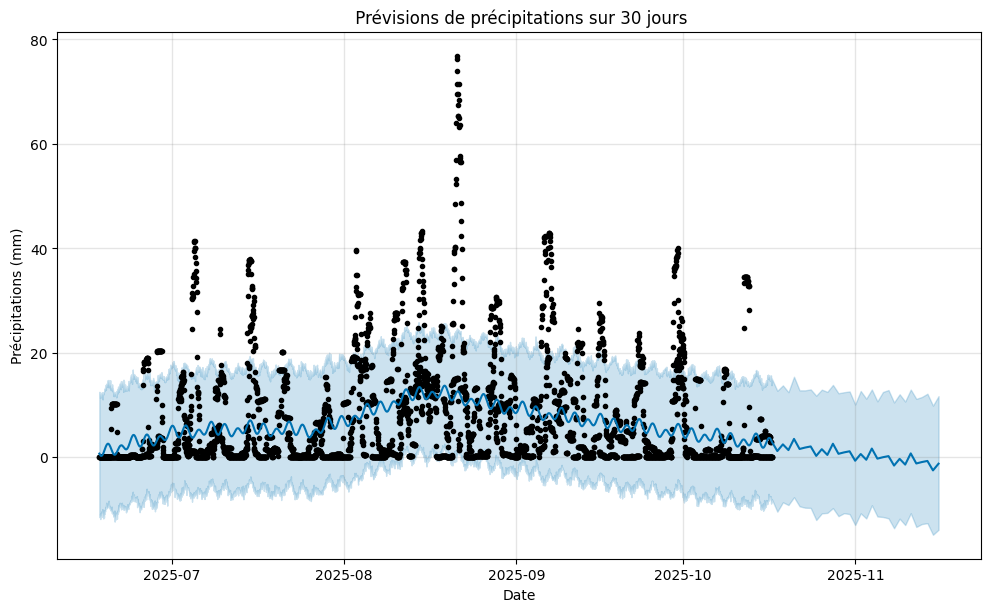

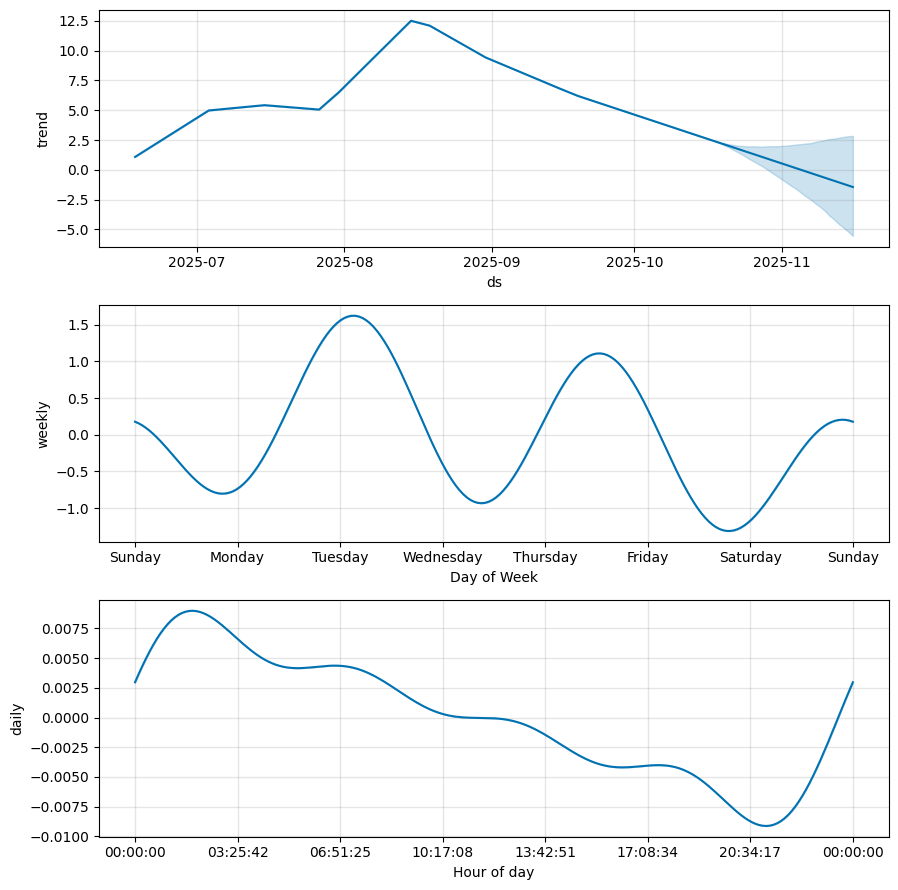

In [ ]:
# Prédire la pluie dans les dates futures (30 jours)
future = model.make_future_dataframe(periods=30)

# 🔮 Prédire les précipitations
forecast = model.predict(future)

# 📊 Visualiser les prévisions
import matplotlib.pyplot as plt

fig1 = model.plot(forecast)
plt.title(" Prévisions de précipitations sur 30 jours")
plt.xlabel("Date")
plt.ylabel("Précipitations (mm)")
plt.grid(True)
plt.show()

# 📊 Visualiser les composantes (tendance, saisonnalité)
fig2 = model.plot_components(forecast)
plt.show()

In [ ]:
# Exporter les prévisions
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].to_csv("previsions.csv", index=False)

In [ ]:
#  Recommandations d'irrigation à partir des prévisions Prophet

def recommander_irrigation(forecast, seuil_secheresse=5, seuil_pluie_excessive=25):
    recommandations = []

    for index, row in forecast.iterrows():
        date = row['ds'].date()
        pluie = row['yhat']

        if pluie < seuil_secheresse:
            recommandations.append(f"{date}  Faible précipitation ({pluie:.1f} mm) : irrigation nécessaire, privilégier micro-irrigation ou goutte-à-goutte.")
        elif pluie > seuil_pluie_excessive:
            recommandations.append(f"{date}  Pluie excessive ({pluie:.1f} mm) : suspendre l'irrigation, vérifier le drainage pour éviter l'engorgement.")
        else:
            recommandations.append(f"{date}  Pluie modérée ({pluie:.1f} mm) : irrigation complémentaire possible selon les besoins des cultures.")

    return recommandations

#  Recommandations
recos_irrigation = recommander_irrigation(forecast)

#  Afficher les 10 premières
for ligne in recos_irrigation[:10]:
    print(ligne)

2025-06-18  Faible précipitation (0.7 mm) : irrigation nécessaire, privilégier micro-irrigation ou goutte-à-goutte.
2025-06-18  Faible précipitation (0.6 mm) : irrigation nécessaire, privilégier micro-irrigation ou goutte-à-goutte.
2025-06-18  Faible précipitation (0.5 mm) : irrigation nécessaire, privilégier micro-irrigation ou goutte-à-goutte.
2025-06-18  Faible précipitation (0.4 mm) : irrigation nécessaire, privilégier micro-irrigation ou goutte-à-goutte.
2025-06-18  Faible précipitation (0.4 mm) : irrigation nécessaire, privilégier micro-irrigation ou goutte-à-goutte.
2025-06-18  Faible précipitation (0.3 mm) : irrigation nécessaire, privilégier micro-irrigation ou goutte-à-goutte.
2025-06-18  Faible précipitation (0.3 mm) : irrigation nécessaire, privilégier micro-irrigation ou goutte-à-goutte.
2025-06-18  Faible précipitation (0.3 mm) : irrigation nécessaire, privilégier micro-irrigation ou goutte-à-goutte.
2025-06-18  Faible précipitation (0.2 mm) : irrigation nécessaire, privi

In [ ]:
pd.DataFrame({'Recommandation irrigation': recos_irrigation}).to_csv("recommandations_irrigation.csv", index=False)

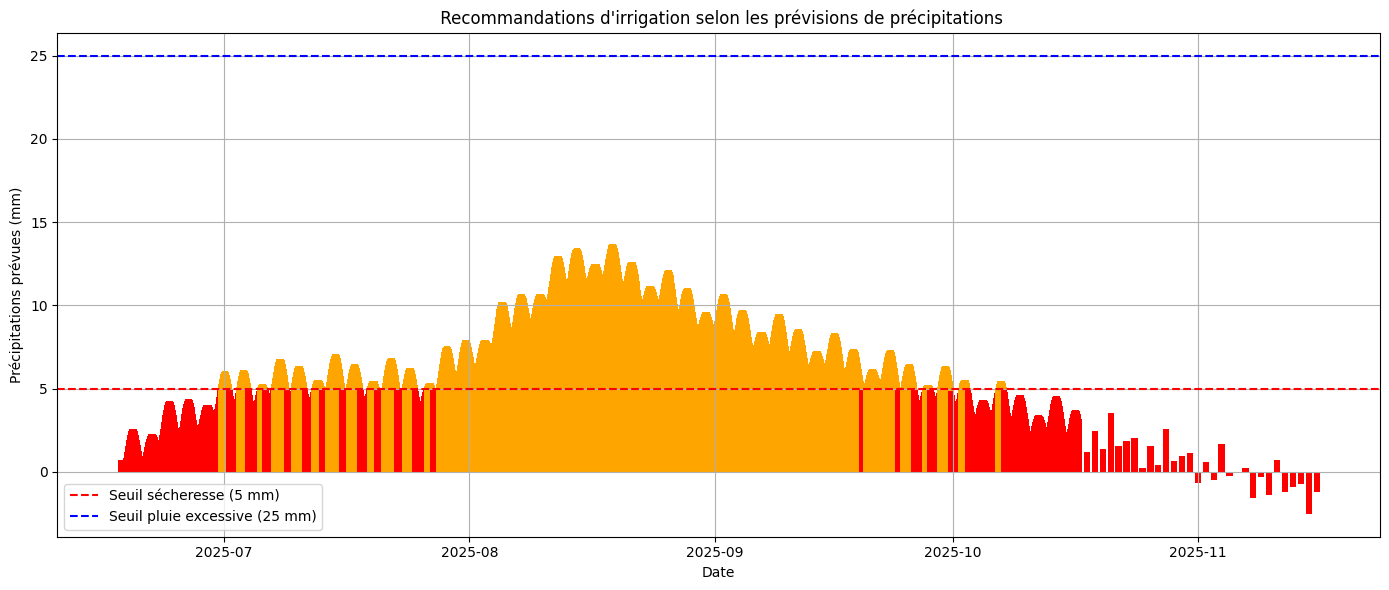

In [ ]:
# Visualisation
import matplotlib.pyplot as plt
import pandas as pd

#  Définir les seuils
seuil_secheresse = 5
seuil_pluie_excessive = 25

#  Déterminer la couleur selon les niveaux
def couleur_irrigation(pluie):
    if pluie < seuil_secheresse:
        return 'red'      # Faible pluie → irrigation nécessaire
    elif pluie > seuil_pluie_excessive:
        return 'blue'     # Pluie excessive → suspendre irrigation
    else:
        return 'orange'   # Pluie modérée → irrigation complémentaire

#  Appliquer les couleurs
forecast['couleur'] = forecast['yhat'].apply(couleur_irrigation)

#  Tracer le graphique
plt.figure(figsize=(14, 6))
plt.bar(forecast['ds'], forecast['yhat'], color=forecast['couleur'])
plt.axhline(seuil_secheresse, color='red', linestyle='--', label='Seuil sécheresse (5 mm)')
plt.axhline(seuil_pluie_excessive, color='blue', linestyle='--', label='Seuil pluie excessive (25 mm)')
plt.title(" Recommandations d'irrigation selon les prévisions de précipitations")
plt.xlabel("Date")
plt.ylabel("Précipitations prévues (mm)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Evaluation du modèle
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Comparaison sur les données historiques
df_eval = forecast.set_index('ds').join(df_prophet.set_index('ds'), how='inner')
mae = mean_absolute_error(df_eval['y'], df_eval['yhat'])
rmse = np.sqrt(mean_squared_error(df_eval['y'], df_eval['yhat']))
print(f"MAE : {mae:.2f} mm | RMSE : {rmse:.2f} mm")

MAE : 6.35 mm | RMSE : 9.06 mm


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


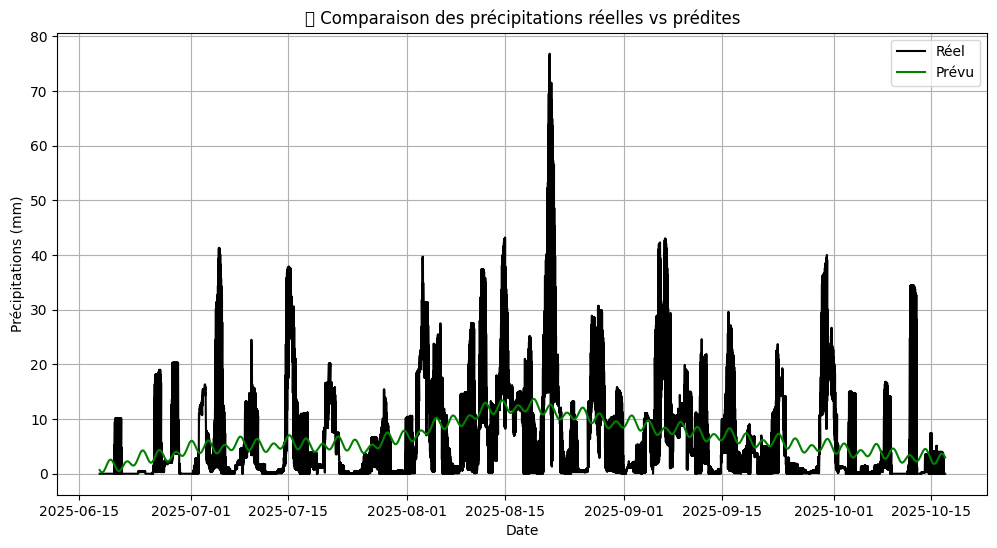

In [ ]:
# Visualiser les erreurs
plt.figure(figsize=(12,6))
plt.plot(df_eval.index, df_eval['y'], label='Réel', color='black')
plt.plot(df_eval.index, df_eval['yhat'], label='Prévu', color='green')
plt.title("📊 Comparaison des précipitations réelles vs prédites")
plt.xlabel("Date")
plt.ylabel("Précipitations (mm)")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Comparer prophet à random forest
#  Créer des features temporelles
df_rf = df_prophet.copy()
df_rf['year'] = df_rf['ds'].dt.year
df_rf['month'] = df_rf['ds'].dt.month
df_rf['day'] = df_rf['ds'].dt.day
df_rf['dayofweek'] = df_rf['ds'].dt.dayofweek

In [ ]:
split_index = int(len(df_rf) * 0.8)
train_rf = df_rf.iloc[:split_index]
test_rf = df_rf.iloc[split_index:]

In [ ]:
# Entrainer Random forest
from sklearn.ensemble import RandomForestRegressor

X_train = train_rf[['year', 'month', 'day', 'dayofweek']]
y_train = train_rf['y']
X_test = test_rf[['year', 'month', 'day', 'dayofweek']]
y_test = test_rf['y']

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

In [ ]:
# Comparer les performances
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Prophet (déjà calculé)
mae_prophet = mae
rmse_prophet = rmse

# Random Forest
mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))

print(f"Prophet → MAE: {mae_prophet:.2f} mm | RMSE: {rmse_prophet:.2f} mm")
print(f"Random Forest → MAE: {mae_rf:.2f} mm | RMSE: {rmse_rf:.2f} mm")

Prophet → MAE: 6.35 mm | RMSE: 9.06 mm
Random Forest → MAE: 6.73 mm | RMSE: 9.96 mm


# Prévision des précipitations et recommandations agricoles

## Objectif
Prévoir les précipitations avec Prophet et générer des recommandations agricoles et d’irrigation dynamiques.

## Contexte
Données météorologiques du Sénégal, saison des pluies 2025. Ce projet vise à soutenir les décisions agricoles.

 ## Méthodologie
- Nettoyage des données
- Modélisation avec Prophet
- Génération de prévisions
- Recommandations d’irrigation
- Évaluation du modèle

 Résultats
**MAE**: **6.35** mm  
**RMSE**: **9.06** mm

 ## Comparaison avec Random Forest
| Modèle          | MAE (mm) | RMSE (mm) |
|----------------|----------|-----------|
| Prophet        | 6.35     | 9.06      |
| Random Forest  | 6.73     | 9.96      |

## Recommandations d’irrigation
- < 5 mm : irrigation nécessaire
- 5–25 mm : irrigation complémentaire
- > 25 mm : suspendre l’irrigation



## 📁 Fichiers
- `Prédiction_pluviométie.ipynb` : Notebook complet
- `previsions.csv` : Prévisions Prophet
- `recommandations_irrigation.csv` : Conseils d’irrigation

##  Auteur
Fatou DIALLO  Ingénieure statisticienne économiste.  
 Basée à Dakar,   
 Passionnée par la data et l'IA.